In [1]:
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
# %matplotlib notebook

# dont want to see all the tensorflow shit
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf


2021-08-18 11:05:27.918351: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-18 11:05:27.918382: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# setting up directories
path_to_data = "/home/isaaccolleran/Documents/sgan/MWA_cands/"
output_path = "/home/isaaccolleran/Documents/sgan/new_models/"
training_labels_file = "/home/isaaccolleran/Documents/sgan/MWA_cands/even_training_labels.csv"
validation_labels_file = "/home/isaaccolleran/Documents/sgan/MWA_validation/validation_labels.csv"
path_to_validation = "/home/isaaccolleran/Documents/sgan/MWA_validation/"

In [3]:
# loading in labels
label_data = pd.read_csv(training_labels_file)
training_labels = label_data['Classification'].to_numpy()
# getting candidate files
base_pfd_files = label_data['Filename'].to_numpy()
# print(label_data[label_data['Filename'] == base_pfd_files[0]])

''' Get file names of a particular classification '''
# pfd_files = [path_to_data + row['Filename'] for idx, row in label_data.iterrows() if row['Classification'] == 0]

''' Get all file names '''
pfd_files = [path_to_data + filename for filename in base_pfd_files]

In [4]:
print(len(pfd_files))

414


In [5]:
# loading and processing data
''' Load Data'''
dm_curve_combined_array = [np.load(filename[:-4] + '_dm_curve.npy') for filename in pfd_files]
pulse_profile_combined_array = [np.load(filename[:-4] + '_pulse_profile.npy') for filename in pfd_files]
freq_phase_combined_array = [np.load(filename[:-4] + '_freq_phase.npy') for filename in pfd_files]
time_phase_combined_array = [np.load(filename[:-4] + '_time_phase.npy') for filename in pfd_files]

# the next 2 steps are basically redundant, because they should already be done, but hey they do it so i'm gonna do it too
''' Reshaping the data for the neural-nets to read '''

reshaped_dm_curve = [np.reshape(f,(60,1)) for f in dm_curve_combined_array]
reshaped_pulse_profile = [np.reshape(f,(64,1)) for f in pulse_profile_combined_array]
reshaped_freq_phase = [np.reshape(f,(48,48,1)) for f in freq_phase_combined_array]
reshaped_time_phase = [np.reshape(f,(48,48,1)) for f in time_phase_combined_array]


''' Rescale the data between -1 and +1 '''

dm_curve_data = np.array([np.interp(a, (a.min(), a.max()), (-1, +1)) for a in reshaped_dm_curve])
pulse_profile_data = np.array([np.interp(a, (a.min(), a.max()), (-1, +1)) for a in reshaped_pulse_profile])
freq_phase_data = np.array([np.interp(a, (a.min(), a.max()), (-1, +1)) for a in reshaped_freq_phase])
time_phase_data = np.array([np.interp(a, (a.min(), a.max()), (-1, +1)) for a in reshaped_time_phase])

In [6]:
''' Loading models'''
labelled_samples = 50814
unlabelled_samples = 265172
attempt_no = 4
freq_phase_model = load_model('semi_supervised_trained_models/freq_phase_best_discriminator_model_labelled_%d_unlabelled_%d_trial_%d.h5'%(labelled_samples, unlabelled_samples,  attempt_no))
time_phase_model = load_model('semi_supervised_trained_models/time_phase_best_discriminator_model_labelled_%d_unlabelled_%d_trial_%d.h5'%(labelled_samples, unlabelled_samples,  attempt_no))
dm_curve_model = load_model('semi_supervised_trained_models/dm_curve_best_discriminator_model_labelled_%d_unlabelled_%d_trial_%d.h5'%(labelled_samples, unlabelled_samples,  attempt_no))
pulse_profile_model = load_model('semi_supervised_trained_models/pulse_profile_best_discriminator_model_labelled_%d_unlabelled_%d_trial_%d.h5'%(labelled_samples, unlabelled_samples,  attempt_no))

# freq_phase_model = load_model('best_retrained_models/freq_phase_best_discriminator_model.h5')
# time_phase_model = load_model('best_retrained_models/time_phase_best_discriminator_model.h5')
# dm_curve_model = load_model('best_retrained_models/dm_curve_best_discriminator_model.h5')
# pulse_profile_model = load_model('best_retrained_models/pulse_profile_best_discriminator_model.h5')

2021-08-18 11:05:40.405405: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-18 11:05:40.406060: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-18 11:05:40.431457: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-08-18 11:05:40.431509: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cira-fishbowl-4
2021-08-18 11:05:40.431523: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cira-fishbowl-4
2021-08-18 11:05:40.431747: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.119.3
2021-08-18 11:05:40.431786: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 450.119.3
2021-08-18 11:05:40.431799: I tensorflow/stream_executor/cuda/cuda_d

In [7]:
# making predictions of all the data
predictions_freq_phase = freq_phase_model.predict([freq_phase_data])
predictions_time_phase = time_phase_model.predict([time_phase_data])
predictions_dm_curve = dm_curve_model.predict([dm_curve_data])
predictions_pulse_profile = pulse_profile_model.predict([pulse_profile_data])

print(predictions_freq_phase.shape)

stacked_results = np.stack((predictions_freq_phase[:,1], predictions_time_phase[:,1], predictions_dm_curve[:,1], predictions_pulse_profile[:,1]), axis=1)
print(stacked_results.shape)
stacked_results = np.reshape(stacked_results, (len(predictions_freq_phase), 4))
print(stacked_results.shape)

2021-08-18 11:05:41.951981: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-18 11:05:41.968831: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3193565000 Hz


(414, 2)
(414, 4)
(414, 4)


# Investigating / Plotting All Predictions

In [8]:
def plot_all_predictions(time_phase, freq_phase, dm_curve, pulse_profile):

    # sort the predictions first
    time_phase.sort(axis=0)
    freq_phase.sort(axis=0)
    dm_curve.sort(axis=0)
    pulse_profile.sort(axis=0)

    # setting up the figures
    fig1 = plt.figure(1)
    plt.plot(time_phase)
    plt.title('Time-Phase')
    plt.ylabel('Prediction')
    plt.xlabel('Array Index')
    plt.legend(['real/fake', 'pulsar/non-pulsar'])

    fig2 = plt.figure(2)
    plt.plot(freq_phase)
    plt.title('Freq-Phase')
    plt.ylabel('Prediction')
    plt.xlabel('Array Index')
    plt.legend(['real/fake', 'pulsar/non-pulsar'])

    fig3 = plt.figure(3)
    plt.plot(dm_curve)
    plt.title('DM Curve')
    plt.ylabel('Prediction')
    plt.xlabel('Array Index')
    plt.legend(['real/fake', 'pulsar/non-pulsar'])

    fig4 = plt.figure(4)
    plt.plot(pulse_profile)
    plt.title('Profile')
    plt.ylabel('Prediction')
    plt.xlabel('Array Index')
    plt.legend(['real/fake', 'pulsar/non-pulsar'])



----- KEY ----- 
Prediction 1 (P1) - real/generated candidate 
Prediction 2 (P2) - pulsar/non-pulsar
----------------

Plot    : [    P1         P2    ]
Time    : [0.2923104  0.29231045]
Freq    : [0.32347935 0.3234794 ]
DM      : [0.20473535 0.20473535]
Profile : [0.25334597 0.253346  ]


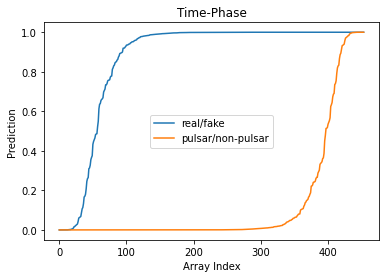

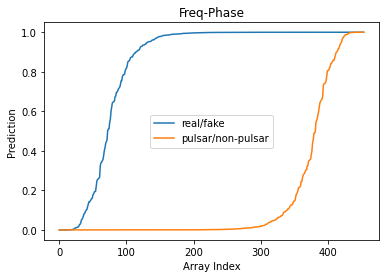

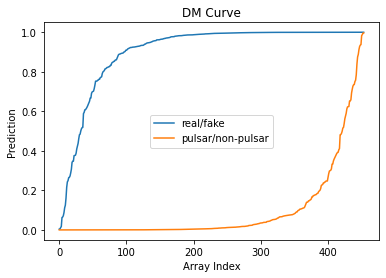

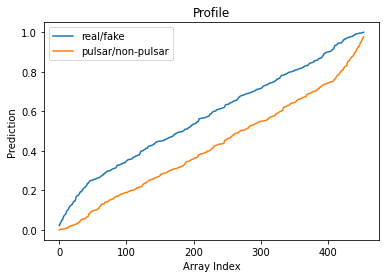

In [9]:
# for plotting the predictions and displaying statistics

print('----- KEY ----- ')
print('Prediction 1 (P1) - real/generated candidate \nPrediction 2 (P2) - pulsar/non-pulsar')
print('----------------\n')

print('Plot    : [    P1         P2    ]')
print('Time    : {}'.format(predictions_time_phase.std(axis=0).round(decimals=8)))
print('Freq    : {}'.format(predictions_freq_phase.std(axis=0).round(decimals=8)))
print('DM      : {}'.format(predictions_dm_curve.std(axis=0).round(decimals=8)))
print('Profile : {}'.format(predictions_pulse_profile.std(axis=0).round(decimals=8)))

plot_all_predictions(predictions_time_phase, predictions_freq_phase, predictions_dm_curve, predictions_pulse_profile)



# Investigating / Plotting Individual Candidates

In [10]:
# Interesting candidates to investigate further
interesting_cands = [
    "Blind_1265470568_08:17:38.83_-24:16:37.85_DM40.12_ACCEL_0:2_1238.11ms_Cand.pfd",
    "Blind_1265470568_08:13:11.15_-34:08:19.84_DM42.10_ACCEL_0:2_1238.11ms_Cand.pfd",
    "Blind_1265470568_08:13:22.11_-33:11:24.13_DM39.88_ACCEL_0:3_1238.03ms_Cand.pfd",
    "Blind_1265470568_08:13:55.77_-33:25:36.80_DM42.52_ACCEL_0:2_1238.11ms_Cand.pfd",
    "Blind_1265470568_08:14:17.00_-31:04:01.83_DM47.86_ACCEL_0:2_1238.20ms_Cand.pfd",
    "Blind_1265470568_08:14:56.85_-34:22:35.96_DM37.24_ACCEL_0:2_1238.20ms_Cand.pfd"
]
# interesting_cands.append("Blind_1265470568_08:13:11.15_-34:08:19.84_DM42.10_ACCEL_0:2_1238.11ms_Cand.pfd")
# interesting_cands.append("Blind_1265470568_08:13:22.11_-33:11:24.13_DM39.88_ACCEL_0:3_1238.03ms_Cand.pfd")
# interesting_cands.append("Blind_1265470568_08:13:55.77_-33:25:36.80_DM42.52_ACCEL_0:2_1238.11ms_Cand.pfd")
# interesting_cands.append("Blind_1265470568_08:14:17.00_-31:04:01.83_DM47.86_ACCEL_0:2_1238.20ms_Cand.pfd")
# interesting_cands.append("Blind_1265470568_08:14:56.85_-34:22:35.96_DM37.24_ACCEL_0:2_1238.20ms_Cand.pfd")

In [11]:
def plotting (subbands, subints, profile, dm_curve, title):
    fig = plt.figure(figsize=(10, 11))

    ax1 = plt.subplot(2, 2, 1)
    subints = subints.reshape((48, 48))
    plt.imshow(subints, cmap='gray')
    ax1.title.set_text('subints')
    ax1.set_ylabel('time')
    
    ax2 = plt.subplot(2, 2, 2)
    subbands = subbands.reshape((48, 48))
    plt.imshow(subbands, cmap='gray')
    ax2.title.set_text('subband')
    ax2.set_ylabel('frequency')
    
    ax3 = plt.subplot(2, 2, 3)
    plt.plot(profile)
    ax3.title.set_text('profile')
    
    ax4 = plt.subplot(2, 2, 4)
    plt.plot(dm_curve)
    ax4.title.set_text('dm curve')
    
    fig.suptitle(title)    
    plt.show()
    # chdir('/home/isaaccolleran/Documents/sgan/cand_pngs/')
    # plt.savefig(title +'.png')
# end def

Blind_1265470568_08:17:38.83_-24:16:37.85_DM40.12_ACCEL_0:2_1238.11ms_Cand.pfd
Freq: [8.4928596e-01 1.3497860e-05]
Time: [9.3578941e-01 3.7462232e-07]
DM: [9.159010e-01 2.741257e-04]
Profile: [0.3548807  0.19091018]


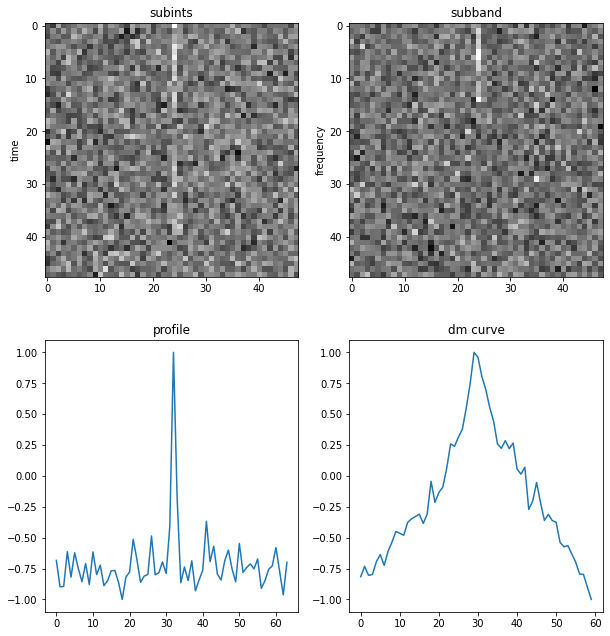

____________________________________________________________________________________________________
Blind_1265470568_08:13:11.15_-34:08:19.84_DM42.10_ACCEL_0:2_1238.11ms_Cand.pfd
Freq: [9.9242532e-01 3.1526707e-04]
Time: [9.9817801e-01 4.3645086e-05]
DM: [0.98256266 0.00233957]
Profile: [0.49685124 0.31966525]


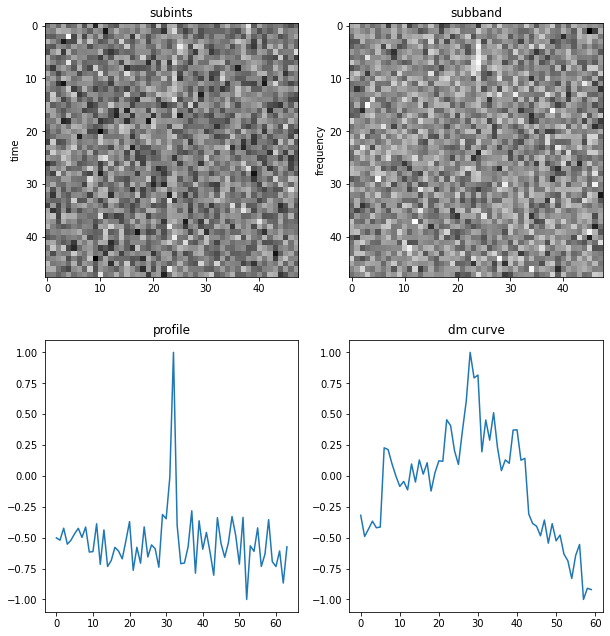

____________________________________________________________________________________________________
Blind_1265470568_08:13:22.11_-33:11:24.13_DM39.88_ACCEL_0:3_1238.03ms_Cand.pfd
Freq: [9.8474842e-01 1.7119749e-04]
Time: [9.9363190e-01 1.4111471e-05]
DM: [0.9706871  0.00140428]
Profile: [0.45989203 0.28912038]


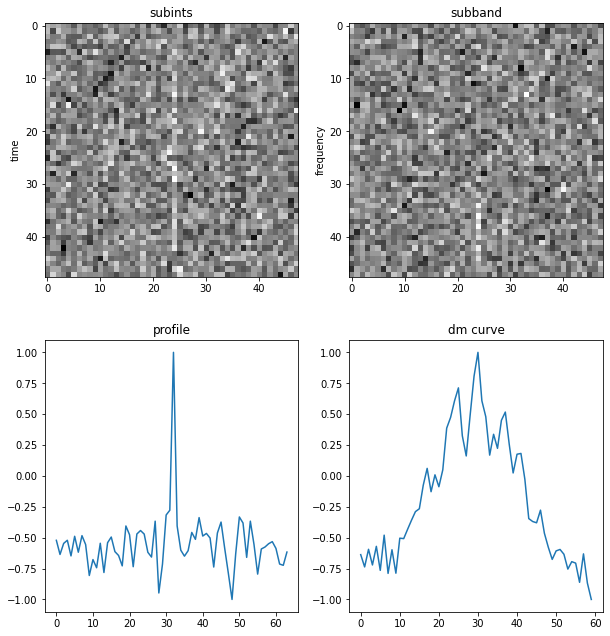

____________________________________________________________________________________________________
Blind_1265470568_08:13:55.77_-33:25:36.80_DM42.52_ACCEL_0:2_1238.11ms_Cand.pfd
Freq: [7.7729660e-01 1.0706746e-05]
Time: [9.0015644e-01 3.2263097e-07]
DM: [8.9457530e-01 2.2213807e-04]
Profile: [0.33612385 0.18366553]


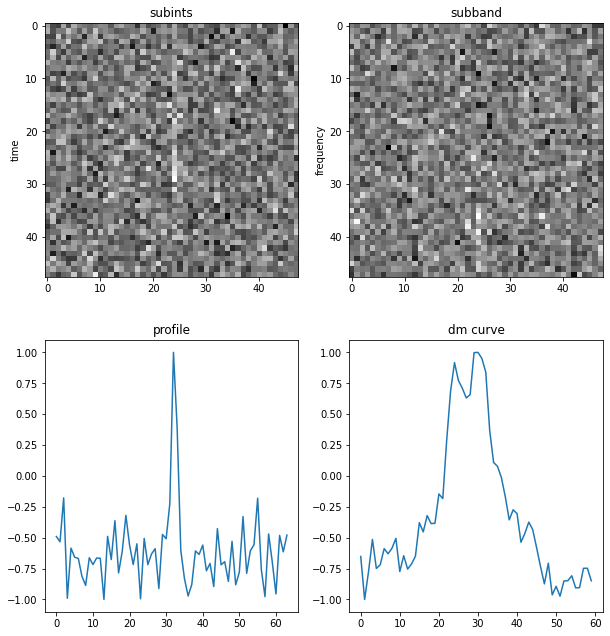

____________________________________________________________________________________________________
Blind_1265470568_08:14:17.00_-31:04:01.83_DM47.86_ACCEL_0:2_1238.20ms_Cand.pfd
Freq: [9.2787606e-01 3.4792258e-05]
Time: [9.7776616e-01 1.4758820e-06]
DM: [9.3326366e-01 5.2096928e-04]
Profile: [0.3970907  0.21750976]


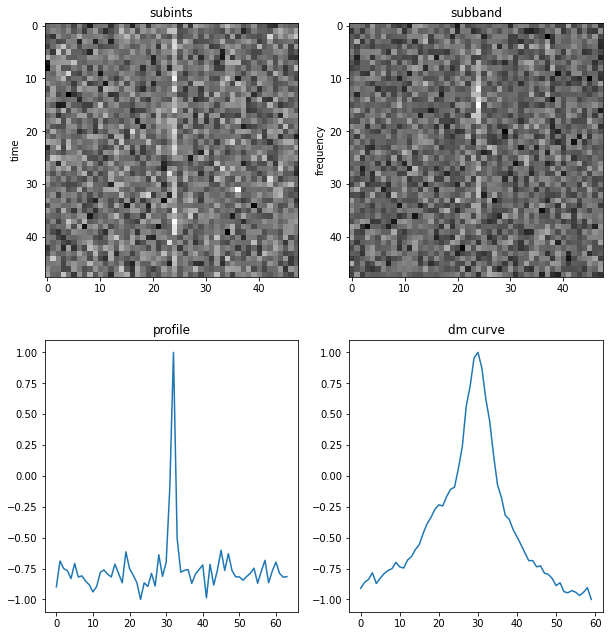

____________________________________________________________________________________________________
Blind_1265470568_08:14:56.85_-34:22:35.96_DM37.24_ACCEL_0:2_1238.20ms_Cand.pfd
Freq: [8.9426166e-01 2.4141256e-05]
Time: [9.5906019e-01 7.9749606e-07]
DM: [9.2610222e-01 4.0554674e-04]
Profile: [0.37050804 0.20723799]


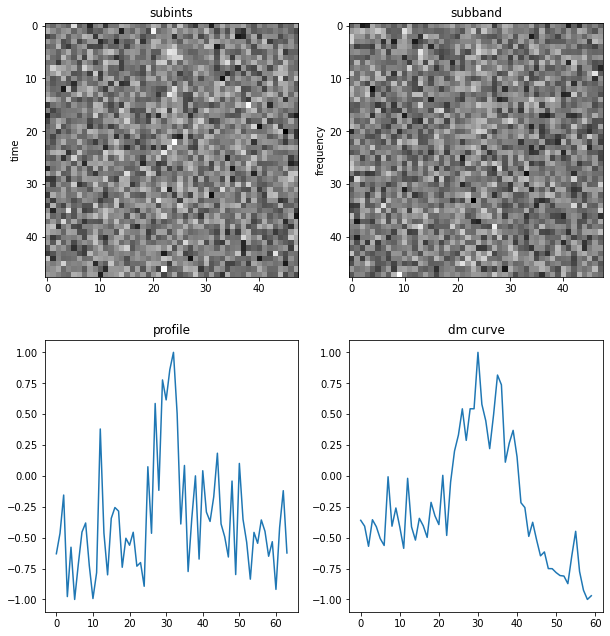

____________________________________________________________________________________________________


In [12]:
# printing the indices that we want
# idx = 4

for i in range(len(interesting_cands)):
    idx = list(base_pfd_files).index(interesting_cands[i])

    print(base_pfd_files[idx])
    print("Freq: {}".format(predictions_freq_phase[idx]))
    print("Time: {}".format(predictions_time_phase[idx]))
    print("DM: {}".format(predictions_dm_curve[idx]))
    print("Profile: {}".format(predictions_pulse_profile[idx]))
    plotting(freq_phase_data[i], time_phase_data[i], pulse_profile_data[i], dm_curve_data[i], '')

    print('____________________________________________________________________________________________________')


    

# Refitting Logistic Regressor

If wanting to quickly retrain the logistic regressor, the cells that need to be compiled are headed with a commented line of dashes.

In [8]:
# extra = "Blind_1265470568_08:17:23.74_-23:34:27.06_DM41.26_ACCEL_0:2_1238.11ms_Cand.pfd"
from ubc_AI.training import pfddata
import pickle

In [27]:
# ----------------------------------------------------------------------------------------------------------------------- #

logistic_model = LogisticRegression()

predictions_freq_phase = freq_phase_model.predict([freq_phase_data])
predictions_time_phase = time_phase_model.predict([time_phase_data])
predictions_dm_curve = dm_curve_model.predict([dm_curve_data])
predictions_pulse_profile = pulse_profile_model.predict([pulse_profile_data])

### With ArgMax

This is a weird approach that was used in the SGAN paper. I've included it in case we are wanting to try and reproduce the results that they produced. It is inclear why they have taken this approach - has not been mentioned in the paper

In [23]:
predictions_time_phase = np.rint(predictions_time_phase)
predictions_time_phase = np.argmax(predictions_time_phase, axis=1)
predictions_time_phase = np.reshape(predictions_time_phase, len(predictions_time_phase))
predictions_time_phase = np.expand_dims(predictions_time_phase, axis=1)
predictions_time_phase = np.insert(predictions_time_phase, 0, np.zeros(len(predictions_time_phase)), axis=1)

predictions_dm_curve = np.rint(predictions_dm_curve)
predictions_dm_curve = np.argmax(predictions_dm_curve, axis=1)
predictions_dm_curve = np.reshape(predictions_dm_curve, len(predictions_dm_curve))
predictions_dm_curve = np.expand_dims(predictions_dm_curve, axis=1)
predictions_dm_curve = np.insert(predictions_dm_curve, 0, np.zeros(len(predictions_dm_curve)), axis=1)

predictions_pulse_profile = np.rint(predictions_pulse_profile)
predictions_pulse_profile = np.argmax(predictions_pulse_profile, axis=1)
predictions_pulse_profile = np.reshape(predictions_pulse_profile, len(predictions_pulse_profile))
predictions_pulse_profile = np.expand_dims(predictions_pulse_profile, axis=1)
predictions_pulse_profile = np.insert(predictions_pulse_profile, 0, np.zeros(len(predictions_dm_curve)), axis=1)

predictions_freq_phase = np.rint(predictions_freq_phase)
predictions_freq_phase = np.argmax(predictions_freq_phase, axis=1)
predictions_freq_phase = np.reshape(predictions_freq_phase, len(predictions_freq_phase))
predictions_freq_phase = np.expand_dims(predictions_freq_phase, axis=1)
predictions_freq_phase = np.insert(predictions_freq_phase, 0, np.zeros(len(predictions_dm_curve)), axis=1)


In [28]:
print(predictions_time_phase.shape, predictions_dm_curve.shape, predictions_pulse_profile.shape, predictions_freq_phase.shape)
print(predictions_time_phase[:,1])

print(stacked_results.shape)

(414, 2) (414, 2) (414, 2) (414, 2)
[3.96614208e-12 1.35521957e-04 3.12152901e-03 9.79078472e-01
 2.11063605e-02 3.95245291e-02 6.33423209e-01 1.50885835e-01
 4.80768308e-02 3.93207102e-07 8.54786579e-03 9.99974728e-01
 6.63671253e-14 7.52812848e-05 2.21349493e-01 2.18113456e-02
 9.99696732e-01 9.98368204e-01 1.56549225e-03 1.10046851e-04
 7.92678237e-01 8.20096672e-01 8.86793792e-01 9.30954702e-03
 8.54601865e-08 1.45814047e-04 2.66174585e-01 9.04416549e-04
 7.50601441e-02 9.12740469e-01 1.19191791e-04 3.80389276e-03
 9.31985140e-01 1.29534621e-02 5.69554993e-11 1.34458773e-07
 1.09118526e-04 1.25728369e-01 9.34035778e-01 3.50970907e-07
 9.55038558e-05 1.15897937e-10 6.86644554e-01 2.09817199e-06
 9.96026039e-01 2.01045768e-04 7.30822137e-07 4.52370867e-02
 4.41975790e-05 2.62930058e-04 1.05450724e-08 3.06292691e-06
 1.31645566e-02 8.64283706e-04 8.93743455e-01 6.50207549e-02
 5.37216701e-02 2.68350970e-02 1.47588196e-06 1.17965628e-05
 1.64942164e-02 9.99104321e-01 1.09059177e-02 5.3

## Fitting model
This is important for specifying which plots we want to include in the fitting process. Uncomment the appropriate pair of lines to suit which plots you wish to include. It is important that you also do the same thing when making the predictions using the validation set below.

In [29]:
# ----------------------------------------------------------------------------------------------------------------------- #

# with DM curve
stacked_results = np.stack((predictions_freq_phase[:,1], predictions_time_phase[:,1], predictions_dm_curve[:,1], predictions_pulse_profile[:,1]), axis=1)
stacked_results = np.reshape(stacked_results, (len(predictions_freq_phase), 4))

# without DM curve
# stacked_results = np.stack((predictions_freq_phase[:,1], predictions_time_phase[:,1], predictions_pulse_profile[:,1]), axis=1)
# stacked_results = np.reshape(stacked_results, (len(predictions_freq_phase), 3))

# without pulse profile and DM curve
# stacked_results = np.stack((predictions_freq_phase[:,1], predictions_time_phase[:,1]), axis=1)
# stacked_results = np.reshape(stacked_results, (len(predictions_freq_phase), 2))

# fitting the logistic regressor
logistic_model.fit(stacked_results, training_labels)

# saving the results
pickle.dump(logistic_model, open('new_models/LogisticRegressor_jupyter.pkl', 'wb'))

In [30]:
print(stacked_results.shape)

(414, 4)


## Loading Validation Data

In [13]:
label_data = pd.read_csv(validation_labels_file)

# validation_labels = label_data['Classification'].to_numpy()

# getting candidate files
base_pfd_files = label_data['Filename'].to_numpy()
pfd_files = [path_to_validation + filename for filename in base_pfd_files]

In [14]:
print(len(pfd_files))
print(training_labels.shape, stacked_results.shape)

60
(414,) (414, 3)


In [15]:
# loading the physical data
validation_dm_curve = [np.load(filename[:-4] + '_dm_curve.npy') for filename in pfd_files]
validation_pulse_profile = [np.load(filename[:-4] + '_pulse_profile.npy') for filename in pfd_files]
validation_freq_phase = [np.load(filename[:-4] + '_freq_phase.npy') for filename in pfd_files]
validation_time_phase = [np.load(filename[:-4] + '_time_phase.npy') for filename in pfd_files]

''' Reshaping the data for the neural-nets to read '''
validation_reshaped_dm_curve = [np.reshape(f,(60,1)) for f in validation_dm_curve]
validation_reshaped_pulse_profile = [np.reshape(f,(64,1)) for f in validation_pulse_profile]
validation_reshaped_freq_phase = [np.reshape(f,(48,48,1)) for f in validation_freq_phase]
validation_reshaped_time_phase = [np.reshape(f,(48,48,1)) for f in validation_time_phase]


''' Rescale the data between -1 and +1 '''
validation_dm_curve_data = np.array([np.interp(a, (a.min(), a.max()), (-1, +1)) for a in validation_reshaped_dm_curve])
validation_pulse_profile_data = np.array([np.interp(a, (a.min(), a.max()), (-1, +1)) for a in validation_reshaped_pulse_profile])
validation_freq_phase_data = np.array([np.interp(a, (a.min(), a.max()), (-1, +1)) for a in validation_reshaped_freq_phase])
validation_time_phase_data = np.array([np.interp(a, (a.min(), a.max()), (-1, +1)) for a in validation_reshaped_time_phase])



In [34]:
# ----------------------------------------------------------------------------------------------------------------------- #

predictions_freq_phase = freq_phase_model.predict(validation_freq_phase_data)
predictions_time_phase = time_phase_model.predict([validation_time_phase_data])
predictions_dm_curve = dm_curve_model.predict([validation_dm_curve_data])
predictions_pulse_profile = pulse_profile_model.predict([validation_pulse_profile_data])


### With ArgMax

In [54]:
predictions_time_phase = np.rint(predictions_time_phase)
predictions_time_phase = np.argmax(predictions_time_phase, axis=1)
predictions_time_phase = np.reshape(predictions_time_phase, len(predictions_time_phase))
predictions_time_phase = np.expand_dims(predictions_time_phase, axis=1)
predictions_time_phase = np.insert(predictions_time_phase, 0, np.zeros(len(predictions_time_phase)), axis=1)

predictions_dm_curve = np.rint(predictions_dm_curve)
predictions_dm_curve = np.argmax(predictions_dm_curve, axis=1)
predictions_dm_curve = np.reshape(predictions_dm_curve, len(predictions_dm_curve))
predictions_dm_curve = np.expand_dims(predictions_dm_curve, axis=1)
predictions_dm_curve = np.insert(predictions_dm_curve, 0, np.zeros(len(predictions_dm_curve)), axis=1)

predictions_pulse_profile = np.rint(predictions_pulse_profile)
predictions_pulse_profile = np.argmax(predictions_pulse_profile, axis=1)
predictions_pulse_profile = np.reshape(predictions_pulse_profile, len(predictions_pulse_profile))
predictions_pulse_profile = np.expand_dims(predictions_pulse_profile, axis=1)
predictions_pulse_profile = np.insert(predictions_pulse_profile, 0, np.zeros(len(predictions_dm_curve)), axis=1)

predictions_freq_phase = np.rint(predictions_freq_phase)
predictions_freq_phase = np.argmax(predictions_freq_phase, axis=1)
predictions_freq_phase = np.reshape(predictions_freq_phase, len(predictions_freq_phase))
predictions_freq_phase = np.expand_dims(predictions_freq_phase, axis=1)
predictions_freq_phase = np.insert(predictions_freq_phase, 0, np.zeros(len(predictions_dm_curve)), axis=1)

In [37]:
# ----------------------------------------------------------------------------------------------------------------------- #

# stacking predictions
# with dm
stacked_predictions = np.stack((predictions_freq_phase[:, 1], predictions_time_phase[:, 1], predictions_dm_curve[:, 1], predictions_pulse_profile[:, 1]), axis=1)
stacked_predictions = np.reshape(stacked_predictions, (len(validation_dm_curve_data),4))

# without dm
# stacked_predictions = np.stack((predictions_freq_phase[:,1], predictions_time_phase[:,1], predictions_pulse_profile[:,1]), axis=1)
# stacked_predictions = np.reshape(stacked_predictions, (len(predictions_freq_phase), 3))

# without pulse profile and DM curve
# stacked_predictions = np.stack((predictions_freq_phase[:,1], predictions_time_phase[:,1]), axis=1)
# stacked_predictions = np.reshape(stacked_predictions, (len(predictions_freq_phase), 2))

In [18]:
# print(predictions_freq_phase[:, 1])
# print(predictions_time_phase[:, 1])
# print(predictions_pulse_profile[:, 1])
print(stacked_predictions)

[[1.8626802e-03 1.3458470e-08 4.7737193e-01]
 [2.3830663e-02 9.9995768e-01 7.3526728e-01]
 [8.3034672e-03 1.6595171e-01 6.4511931e-01]
 [5.9217825e-03 2.2690244e-02 3.1907621e-01]
 [2.7476752e-05 2.6168800e-06 8.3280909e-01]
 [2.1409784e-01 2.7351778e-03 4.1532186e-01]
 [2.0117266e-06 3.4496099e-01 3.0142909e-01]
 [8.5373438e-05 2.7442130e-03 1.9889429e-01]
 [7.0682148e-07 5.0778633e-01 1.4805491e-01]
 [9.2779332e-01 2.9166019e-02 8.7092692e-01]
 [7.7876174e-01 4.3397853e-03 6.0471535e-01]
 [5.3561642e-04 9.7018492e-01 7.6456642e-01]
 [9.7160250e-01 9.9999917e-01 9.3389434e-01]
 [9.2042587e-04 4.7576423e-06 8.8765748e-02]
 [1.0491033e-05 2.7154742e-02 4.8864064e-01]
 [1.9645341e-01 1.5085239e-03 3.1340346e-01]
 [1.0000000e+00 1.0000000e+00 9.2102313e-01]
 [5.1040058e-07 1.1222457e-07 1.9001125e-01]
 [7.5138727e-04 3.5779044e-07 1.9890542e-01]
 [4.5731527e-04 9.9608117e-01 6.3130921e-01]
 [7.4477766e-06 1.8800745e-02 1.5464878e-01]
 [6.8724120e-01 9.9999976e-01 9.5513850e-01]
 [8.057186

In [38]:
# ----------------------------------------------------------------------------------------------------------------------- #

# testing Logistic Regressor
logistic_model = pickle.load(open('new_models/LogisticRegressor_jupyter.pkl', 'rb'))

# classified_results = logistic_model.predict(stacked_predictions) # if you want a classification score

classified_results = logistic_model.predict_proba(stacked_predictions)[:,1] # If you want a regression score

print(classified_results[0:30])
print('{} / 30'.format(int(sum(np.rint(classified_results[0:30])))))
print(classified_results[30:])
print('{} / 30'.format(int(30 - sum(np.rint(classified_results[30:])))))

[0.41606489 0.90632081 0.62778171 0.30609752 0.69882562 0.48788276
 0.4146059  0.21977413 0.36013991 0.95988934 0.86954993 0.905663
 0.99449695 0.16289779 0.43565854 0.39387395 0.99561124 0.21934448
 0.21940718 0.86547035 0.19989571 0.98945155 0.23988246 0.7514424
 0.49223384 0.95243121 0.82463819 0.87355608 0.68439685 0.53900358]
16 / 30
[0.23772801 0.23445146 0.5302804  0.17429019 0.5732014  0.15564323
 0.59230805 0.45148779 0.23119744 0.14272616 0.37275534 0.1638106
 0.56333504 0.19377565 0.40028423 0.15430799 0.24463094 0.18971975
 0.38484242 0.51114391 0.80760718 0.12938465 0.22789997 0.13482815
 0.13610477 0.19901191 0.40754442 0.17727524 0.34612786 0.4452968 ]
24 / 30
